<span style="font-size:9pt">Copyright Jean-Luc CHARLES (Jean-Luc.charles@ensam.eu) 2022 CC BY-SA 4.0</span>

# Machine learning avec les modules Python tensorflow2/keras :

# Entraînement d'un réseau de neurones dense à classifier des données issues d'un banc de perçage

version 3.1 du 6 novembre 2022

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    Ce notebook doit être chargé dans un processus <b>jupyter notebook</b> lancé dans l'EVP <b><span style="color: rgb(80, 151, 102);">minfo_ml</span></b> créé en suivant la procédure du document <b>Consignes.pdf</b>.

## Import des modules Python requis :

In [1]:
import os, sys

# clean tensorflow warnings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# the seed to make random genetors repetables:
SEED = 1234 

import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"numpy     : {np.__version__}")

Python    : 3.8.13
tensorflow: 2.8.0 incluant keras 2.8.0
numpy     : 1.21.2


### Définition de la fonction `read_csv` qui sera utilisée pour la lecture des fichiers CSV :

In [2]:
def read_csv(file: str, last_param_rank:int, verbose=False) -> (np.ndarray, np.ndarray, list, list):
    '''
    Lire les fichiers CSV (Comma Separated Values) en 'corrigeant les petits défauts'.
    Paramètres: 
      file:str: nom du fichier à lire
      last_param_rank:int: le rang de la dernière colonne paramètre (commençant à 0)
      verbole:bool: mode verbeux ou non-verbeux
    Renvoie:
      data:ndarray: le tableau ndarray des valeurs lues
      label:ndarray: le tableau des labels
      param:str: la liste des paramètres
      header:str: l'entête des colonnes du fichier CSV
    '''
    param, data, label, header = [], [], [], []
    with open(file, encoding='utf8') as f:
        for i, line in enumerate(f):
            if i == 0: 
                header=line.strip().split(';')
                continue
            if verbose: print(i,line)
            line = line.strip().replace(',','.').split(';')
            list_param = line[:last_param_rank+1]    # from 0 to 'last_param_rank' excluded: the parameters
            list_data  = line[last_param_rank+1:-3]  # from rank 'last_param_rank' to the end: the data
            list_label = line[-1]                    # last column: the labels
            param.append(list_param)
            data.append(list_data)
            label.append(list_label)
    data = np.array(data).astype(float)
    label = np.array(label).astype(int)
    return data, label, param, header

# 1 - Lire le fichier CSV et préparer les données labellisées

## 1.1 $-$ Lire le fichier CSV :

Ouvrir le fichier CSV `Dataset.csv` avec un tableur ; le fichier est organisé en colonnes :
- la colonne `A` (*rank: 0*) donne le numéro de l'essai de perçage,
- suivent plusieurs colonnes donnant, dans l'ordre des rangs croisants :
    - les **paramètres** de perçage, commençant avec la colonne `B` (*rank: 1*) de label `Longueur percee eprouvetteAlCFRP(mm)`,
    - les **indicateurs caractéristiques** (les *features*), commençant avec la colonne de label `KcFz`: ces indicateurs sont calculée avec les données brutes acquises sur le banc de perçage avec les différents capteurs (accéléromètre, capteur de courant...).
    
Le détails des traitements permettant d'obtenir certains des indicateurs avec les données temporelles brutes fera l'objet de séances de travail dédiées.

À l'aide de la fonction `read_csv` définie ci-dessus, lire le fichier `Dataset.csv` situé dans le répertoire courant:
- en observant le fichier `Dataset.csv` ouvert dans un tableur, trouver la valeur du rang de la dernière colonne des paramètres,
- nommer `data`, `label`, `param` et `header` les objets renvoyés par la fonction...

In [3]:
data, label, param, header = read_csv('Dataset.csv', 14)

Faire afficher l'attribut `shape` des tableaux `data` et `label`:

In [4]:
data.shape, label.shape 

((356, 50), (356,))

Est-ce que ces valeurs paraissent en cohérence avec le contenu du ficher CSV ?<br>
Il est important de pouvoir expliquer les valeurs des dimensions des tableaux....

Vérifier les données de la première ligne du tableau `data` par comparaison visuelle avec le tableur :

In [5]:
# un coup d'oeil sur la première ligne ds données: 50 nombres flottants
data[0]  

array([ 4.07111857e+02,  4.67130779e+02, -1.68192509e+01,  2.59126697e+02,
        1.41883454e+02, -1.44707830e+00, -2.38782680e-01,  2.01309146e+04,
        1.27532583e+00,  5.24100367e+00, -4.25671060e+00,  8.11744892e-01,
        1.92336596e+00, -6.80682771e-01, -3.58838557e-01,  3.69933662e+00,
        1.13944183e+01,  4.83412238e+00,  2.92271392e+00,  5.08095204e-01,
        3.40000000e-01,  2.93000000e-01,  3.23402597e-01,  1.67168838e-02,
       -5.48846864e-01, -9.12838318e-01,  2.79454204e-04,  3.56627661e+01,
        2.32420000e+01,  2.18260000e+01,  2.26993506e+01,  4.28199252e-01,
       -5.44160812e-01, -7.39967001e-01,  1.83354599e-01,  1.07218644e+01,
        4.90193646e+00,  1.96512667e+02,  7.90036820e-01,  3.66294500e-01,
        1.15993290e+00,  3.71161500e-02,  1.43772460e-01,  1.25540392e+00,
        6.61860700e-02,  2.65101880e-01,  5.50328425e+00,  2.65337700e-02,
        4.00878300e-02,  2.41660816e+00])

Faire afficher le tableau `label` :

In [6]:
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Le tableau `label` montre qu'on a d'abord des essais de perçage avec le matériau `0`, puis avec le matériau `1`<br>
=> il faudra faire des tirages aléatoires (*shuffle*) plus loin pour que l'apprentissage du réseau de neurones puisse se faire....

## 1.1 $-$ Normaliser les données

Vous devez ici modifier chacune des lignes du tableau `data` pour les normaliser : les valeurs de chaque ligne après normalisation doivent être comprises dans l'intervalle [0; 1]... 

Vous devriez arriver à obtenir ce résultat sans écrire de boucle sur les lignes du tableau, mais en utilisant la vectorisation possible avec les tableaux `ndarray` du module *numpy*.

In [7]:
data.shape

(356, 50)

In [8]:
# la méthode `ndarray.ptp` renvoie la valeur *peak to peak* selon les diffétents xes d'un tableau:
data.ptp(axis=0)

array([6.65773857e+02, 7.76926771e+02, 9.01715406e+02, 3.16359987e+02,
       4.54801056e+02, 1.58164593e+00, 1.71039274e+00, 2.44883928e+05,
       1.12060826e+01, 2.39241562e+01, 3.15157255e+01, 5.70613725e+00,
       1.42556248e+01, 2.25965991e+00, 2.18046092e+00, 2.40515840e+02,
       1.73404654e+01, 1.53571740e+01, 7.65412368e+00, 1.27643536e+00,
       6.67000000e-01, 6.33000000e-01, 6.40356190e-01, 4.59459697e-02,
       1.05731625e+01, 4.38592951e+00, 2.58594148e-03, 8.85911598e+01,
       5.10740000e+01, 3.25690000e+01, 4.47553500e+01, 7.14764254e+00,
       2.88936058e+01, 7.85243202e+00, 5.20549778e+01, 9.54793155e+00,
       1.28384677e+02, 6.05711056e+02, 2.74887212e+00, 3.45725083e+00,
       1.70195724e+01, 1.48686958e+00, 2.22512623e+00, 9.24896088e+00,
       2.85502199e-01, 2.94460771e+00, 2.01135163e+01, 1.97121590e-01,
       5.56762630e-01, 6.15654828e+00])

In [9]:
# On peut normaliser les lignes du tableau en retranchant à chaque ligne sa valeur minimale 
# et en la divisant par sa valeur *peak to peak*:

data = (data - data.min(axis=0))/data.ptp(axis=0)

#### Vérification

Les valeurs de chacune des ligne du tableau `data` doivent être comprises entre 0 et 1:

In [10]:
print(f"valeurs min des lignes du tableau 'data' normalisé : \n{data.min(axis=0)}\n" 
      f"valeurs max des lignes du tableau 'data' normalisé : \n{data.max(axis=0)}")

valeurs min des lignes du tableau 'data' normalisé : 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
valeurs max des lignes du tableau 'data' normalisé : 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


## 1.2 $-$ Découper les données en un jeu d'entraînement et un jeu de test

Avec l'aide de la page [sklearn.model_selection.train_test_split.html](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) utiliser la fonction `train_test_split` pour découper le tableau `data` en deux jeux de données labellisées :
- `data_train` et `label_train` $\leadsto$ données et labels d'entraînement,
- `data_val` et `label_val`  $\leadsto$  donnnées et labels de validation.<br>
On pourra par exemple regrouper 20% des données et labels pour le jeu de validation.

Il est important de passer à `train_test_split` les arguments :
- `stratify=label`, afin de répartir équitablement toutes les classes sur les deux jeux de données,
- `shuffle=True`, pour mélanger les données,
- `random_state=SEED`, pour obtenir un mélange aléatoire des données qui soit reproductible...


In [11]:
from sklearn.model_selection import train_test_split

data_train, data_val, label_train, label_val = train_test_split(data, label, 
                                                                stratify=label, 
                                                                test_size=0.2,        # 20 % test, 80% train 
                                                                random_state=SEED,    # fixer la graine des génés aléatoires
                                                                shuffle=True)         # mélanger aléatoirement les données

Vérification des dimensions des tableaux:

In [12]:
data_train.shape, data_val.shape

((284, 50), (72, 50))

In [13]:
label_train.shape, label_val.shape

((284,), (72,))

Il est important de savoir expliquer les dimensions des tableaux...

## 1.4 $-$ Créer les labels au format 'one hot'

Définir `y_train` et `y_val`, les tableaux des labels d'entraînement et de test au format *one hot* : 

In [14]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(label_train)
y_val   = to_categorical(label_val)

Vérifier visuellement les 5 premières valeurs des tableaux `label_train` et `y_train` puis `label_val` et `y_val`:

In [15]:
label_train[:5], y_train[:5]

(array([1, 0, 0, 1, 1]),
 array([[0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]], dtype=float32))

In [16]:
label_val[:5], y_val[:5]

(array([1, 0, 1, 0, 0]),
 array([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]], dtype=float32))

## 1.5 $-$ Définitions de paramètres utiles

En utilisant l'attribut `shape` des tableaux *ad-hoc*, définir les paramètres suivants :

In [17]:
nb_train_set = data_train.shape[0]    # nombre de jeux d'entraînement
nb_val_set   = data_val.shape[0]      # nombre de jeux de validation
set_size     = data_train.shape[1]    # nombre de réels (float) dans un jeu
nb_classe    = 2                      # nombre de classes de matériaux 

Vérification :

In [18]:
print(f"{nb_train_set} jeux d'entraînement  et {nb_val_set} jeux de validation, comprenant {set_size} scalaires dans chaque jeu")

284 jeux d'entraînement  et 72 jeux de validation, comprenant 50 scalaires dans chaque jeu


# 2 $-$ Construction et entraînement du réseau de neurones dense

## 2.1 $-$ Construction du réseau dense

En vous appuyant sur les acquis d'apprentissage de l'auto-formation, contruire le RND `model` conforme aux spécifications :
- couche d'entrée compatible avec les dimensions du jeu de connées construit plus haut, nommée `Input`,
- couche cachée de 100 neurones, fonction d'activation `relu`, nommée `C1`,
- couche de sortie permettant de classifier deux matières percées, nommée `Out`,<br>

Compiler le réseau avec les paramètres *ad-hoc* et faire afficher sa structure avec la méthode `summary`.

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

# set the seed for repetable tenssorflow random sequences:
tf.random.set_seed(SEED)

model = Sequential()
model.add(Input(shape=(set_size,), name='Input'))
model.add(Dense(100, activation='relu', name='C1'))
model.add(Dense(nb_classe, activation='softmax', name='Out'))
model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Dense)                  (None, 100)               5100      
                                                                 
 Out (Dense)                 (None, 2)                 202       
                                                                 
Total params: 5,302
Trainable params: 5,302
Non-trainable params: 0
_________________________________________________________________


Affichage graphique de la structure du réseau :

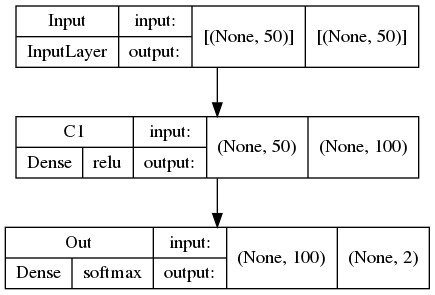

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

## 2.2 $-$ Sauvegarde des poids initiaux du réseau de neurones

- Enregistrer les poids du réseau de neurone initial dans le dossier `weights` avec le préfixe `dense_init`.
- Faire afficher la liste des fichiers du dossier `weights` qui commencent par `dense_init`.

In [21]:
# check that the directory exists and create it if required:
if not os.path.isdir("weights"): os.mkdir("weights")

# save the network weights:
key = 'dense_init'
model.save_weights(os.path.join('weights', key))

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/dense_init.data-00000-of-00001
weights/dense_init.index


## 2.3 $-$ Entraînement du réseau de neurones

- Recharger les poids initiaux du réseau.
- Fixer la graine des génératoires aléatoire de **tensorflow**.
- Entraîner le réseau, avec mesure des parformance à chaque époque, en essayant de trouver par essais successifs des valeurs des argumenst `epoch` et `batch_size` qui donnent des courbes `accuracy` et `loss` satisfaisantes...

In [22]:
from time import time
t0 = time()

# reload the initial state of the NN to get repetable results:
key = 'dense_init'
model.load_weights(os.path.join('weights', key))

# set the seed for repetable tenssorflow random sequences:
tf.random.set_seed(SEED)

# train the network
hist = model.fit(data_train, y_train,
                 validation_data=(data_val, y_val), 
                 epochs=10, 
                 batch_size=128)
temps_calcul = time() - t0
print(f"Durée entraînement : {temps_calcul:.2f} secondes")

Epoch 1/10
3/3 [==============================] - 1s 76ms/step - loss: 0.6406 - accuracy: 0.7007 - val_loss: 0.6023 - val_accuracy: 0.7083
Epoch 2/10
3/3 [==============================] - 0s 12ms/step - loss: 0.5791 - accuracy: 0.8169 - val_loss: 0.5462 - val_accuracy: 0.8611
Epoch 3/10
3/3 [==============================] - 0s 15ms/step - loss: 0.5243 - accuracy: 0.9085 - val_loss: 0.4931 - val_accuracy: 0.9444
Epoch 4/10
3/3 [==============================] - 0s 13ms/step - loss: 0.4720 - accuracy: 0.9718 - val_loss: 0.4410 - val_accuracy: 0.9583
Epoch 5/10
3/3 [==============================] - 0s 13ms/step - loss: 0.4232 - accuracy: 1.0000 - val_loss: 0.3936 - val_accuracy: 0.9861
Epoch 6/10
3/3 [==============================] - 0s 12ms/step - loss: 0.3784 - accuracy: 1.0000 - val_loss: 0.3524 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 0s 12ms/step - loss: 0.3389 - accuracy: 1.0000 - val_loss: 0.3154 - val_accuracy: 1.0000
Epoch 8/10
3/3 [===========

### Affichage des courbes *accuracy* et *loss* :

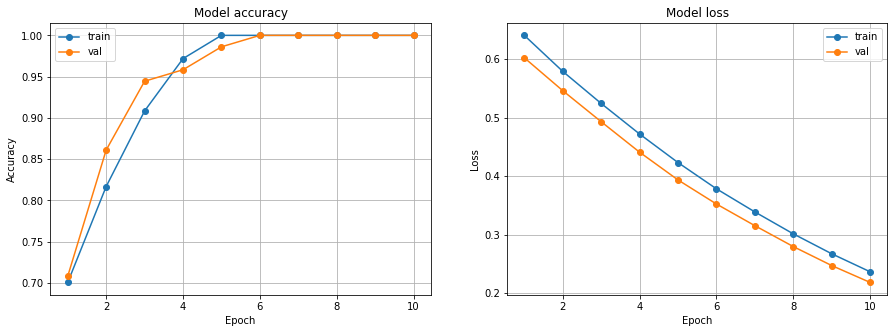

In [23]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

### Sauvegarde des poids du réseau entraîné :

- Enregistrer les poids du réseau de neurone initial dans le dossier `models` avec le préfixe `trained`.
- Faire afficher la liste des fichiers du dossier `weights` qui commencent par `trained`.

In [24]:
dir_name = "models"      # name of the directory where to save files 
if not os.path.exists(dir_name): os.mkdir(dir_name)

key = 'trained'
model.save_weights(os.path.join(dir_name, key))

# print file list:
files=[f for f in os.listdir(dir_name) if f.startswith(key)]
files.sort()
print(f"weight files in directory '{dir_name}':")
for f in files: print('\t',f)

weight files in directory 'models':
	 trained.data-00000-of-00001
	 trained.index


# 3 $-$ Évaluation du réseau entraîné

Calculer les inférences du réseau entraîné en lui donnant les données de validation :

In [25]:
results = model.predict(data_val)
inferences = results.argmax(axis=-1)

print(f"inferences : {inferences}")

inferences : [1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0
 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1]


Calculer la précison (pourcentage de bonnes réponses) du réseau entraîné :

In [26]:
reponse_ok = (inferences == label_val)
print(f"nombre de réponses justes : {reponse_ok.sum()} sur {nb_val_set} jeux de données")

precision = reponse_ok.sum()/nb_val_set*100
print(f"précision du réseau entraîné : {precision} % de réponses justes")

nombre de réponses justes : 72 sur 72 jeux de données
précision du réseau entraîné : 100.0 % de réponses justes


Faire afficher la matrice de confusion, avec les labels écrits explicitement :

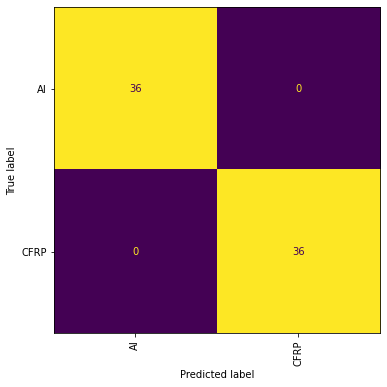

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig = plt.figure(figsize=(6,6))
axis = plt.axes()
ConfusionMatrixDisplay.from_predictions(label_val, inferences, 
                                        ax=axis,
                                        display_labels=['Al','CFRP'], 
                                        xticks_rotation='vertical',
                                        colorbar=False);

# 4 - Entraînement du réseau de neurones avec seulement 1 indicateur à la fois prami les 50

## 4.1 $-$ Construction du réseau de neurones pour 1 indicateur en entrée :

Définir le RND `model_1` identique au RND `model` sauf pour la couche d'entrée qui sera dimensionnée à `1`, compiler le réseau et faire afficher sa structure :

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

nb_train_set = data_train.shape[0]    # number of training sets
nb_val_set   = data_val.shape[0]      # number of validation sets 
set_size     = 1                      # number of scalars in a set 
nb_classe    = 2                      # number of classes (material1, material2)

tf.random.set_seed(SEED)

# les 5 lignes pour construire le réseau de neurones:
model_1 = Sequential()
model_1.add(Input(shape=(set_size,), name='Input'))
model_1.add(Dense(100, activation='relu', name='C1'))
model_1.add(Dense(nb_classe, activation='softmax', name='Out'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

model_1.summary()    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Dense)                  (None, 100)               200       
                                                                 
 Out (Dense)                 (None, 2)                 202       
                                                                 
Total params: 402
Trainable params: 402
Non-trainable params: 0
_________________________________________________________________


Affichage graphique de la structure du réseau :

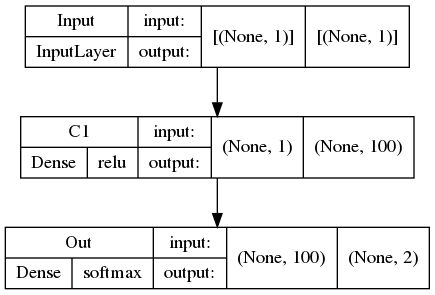

In [29]:
tf.keras.utils.plot_model(model_1, show_shapes=True, show_layer_activations=True)

### Sauvegarde des poids initiaux du réseau de neurones

- Enregistrer les poids du réseau de neurone initial dans le dossier `weights` avec le préfixe `dense_1_init`.
- Faire afficher la liste des fichiers du dossier `weights` qui commencent par `dense_1_init`.

In [30]:
# check that the directory exists and create it if required:
if not os.path.isdir("weights"): os.mkdir("weights")

# save the network weights:
key = 'dense_1_init'
model_1.save_weights(os.path.join('weights', key))

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/dense_1_init.data-00000-of-00001
weights/dense_1_init.index


## 4.2 $-$ Entraînement du réseau avec chacun des 50 indicateurs pris séparément

À cette étape du problème, l'idée est d'entraîner le RND non plus avec la globalité des 50 indicateurs $\times$ 236 données, mais de considérer les indicateurs un par un, pour voir quelle est la précision du réseau entraîné avec les données de chaque indicateur pris séparément...

Construire une boucle réalisant 50 itérations, et à chaque itération `i` :
- extraire les données d'entraînement et de validation pour l'indicateur de rang `i`,
- charger les poids initiaux du RND `model_1`,
- fixer la graine des générateurs aléatoires de **tensorflow**,
- entraîner le réseau, avec mesure des performance à chaque époque, en conservant les valeurs des arguments `epoch` et `batch_size` précédemment utilisées,
- calculer les inférences scalaires du réseau entrainé pour les données de validation, en déduire la précision du préseau entraîné avec l'indicateur de rang `i`,
- stocker dans la liste `accuracy` la précision du réseau entraîné.

In [31]:
from time import time

accuracy = []

t0 = time()
for i in range(50):
    
    # take the indicator and the label of rank <i>:
    data_train_1 = data_train[:,i]
    data_val_1   = data_val[:,i]

    # reload the initial NN state:
    key = 'dense_1_init'
    model_1.load_weights(os.path.join('weights', key))

    tf.random.set_seed(SEED)
    
    # train the NN:
    print(f"\r",i, end="")
    hist = model_1.fit(data_train_1, y_train,
                       validation_data=(data_val_1, y_val), 
                       epochs=10, 
                       batch_size=128,
                       verbose=0)
    
    # evaluate the NN:
    inf_1 = model_1.predict(data_val_1).argmax(axis=-1)
    ok = (inf_1 == label_val)
    ac = ok.sum()/nb_val_set*100
    accuracy.append(ac)

print(f"\n50 entraînement en {(time()-t0):.0f} secondes")    
accuracy = np.array(accuracy)

 49
50 entraînement en 22 secondes


## 4.3 $-$ Recherche des indicateurs les plus pertinents pour l'entraînement du RND 

L'allure de la courbe précédente suggère que certains indicateurs n'offrent aucune pertinence pour la classification du matériau percé (précision égale à 50 % $\leadsto$ la même que si on classait les deux matériaux au hasard...), alors que certains indicateurs à eux seuls conduisent à des précisions de classification supérieures à 80%...

Faire afficher les labels des indicateurs donnant un réseau entraîné dont la précision est meilleure que 70% :

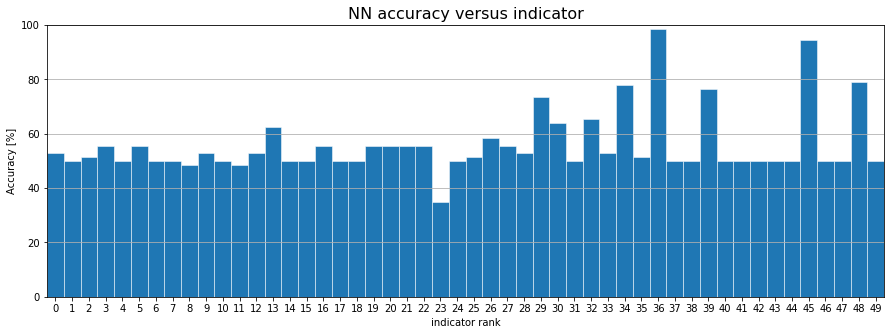

In [32]:
x = list(range(50))
labels = list(range(50))
fig, ax = plt.subplots(figsize=(15,5))

width=1
ax.bar(x, accuracy, width=width, edgecolor="white", linewidth=0.5)
ax.set_ylabel('Accuracy [%]')
ax.set_xlabel('indicator rank')
ax.set_title('NN accuracy versus indicator', fontsize=16)
ax.set_xticks(x, labels)
ax.set_xlim(0-width/2, 50-width/2)
ax.set_ylim(0,100)
ax.grid(axis='y')
plt.show()

## 4.3 $-$ Recherche des indicateurs les plus pertinents pour l'entraînement du RND 

L'allure de la courbe précédente suggère que certains indicateurs n'offrent aucune pertinence pour la classification du matériau percé (précision égale à 50 % $\leadsto$ la même que si on classait les deux matériaux au hasard...), alors que certains indicateurs à eux seuls conduisent à des précision de classification supérieure à 80%...

Faire afficher les labels des indicateurs donnant un réseau entraîné dont al précision est supérieure ou égale à 70% :

In [33]:
labels = np.array(header[15:-3])
accuracy = np.array(accuracy)
ranks = np.where(accuracy >= 70)[0]
for acc, indicator, rank in zip(accuracy[ranks], labels[ranks], ranks):
    print(f"{acc:.0f}% avec l'indicateur '{indicator}', rang {rank}")

74% avec l'indicateur 'min Itorque', rang 29
78% avec l'indicateur 'varITorque', rang 34
99% avec l'indicateur 'AmpFz_passage dents', rang 36
76% avec l'indicateur 'AmpMz_passage dents', rang 39
94% avec l'indicateur 'AmpVzpiece_passage dents', rang 45
79% avec l'indicateur 'AmpVypiece_passage dents', rang 48


## 4.4 $-$ Pertinence des indicateurs liés aux capeturs électriques

Parmi les 50 indicateurs, ceux dont le label commence par `'Amp'` correspondent à des caractéristiques calculées avec des données temporelles brutes de capteurs électriques : ces indicateurs sont intéressants, car les bancs de perçage sont équipés nativement de ce type de capteurs.

Construire la liste `indic_elec` des tuples `(rang, label)` pour les indicateurs dont le label commence par `'Amp'` :

In [34]:
indic_elec = [(i, name) for i, name in enumerate(header[15:-3]) if name.startswith('Amp')]
indic_elec

[(35, 'AmpFz_Frot'),
 (36, 'AmpFz_passage dents'),
 (37, 'AmpFz_Fvib'),
 (38, 'AmpMz_Frot'),
 (39, 'AmpMz_passage dents'),
 (40, 'AmpMz_Fvib'),
 (41, 'AmpVzUPA_Frot'),
 (42, 'AmpVzUPA_passage dents'),
 (43, 'AmpVzUPA_Fvib'),
 (44, 'AmpVzpiece_Frot'),
 (45, 'AmpVzpiece_passage dents'),
 (46, 'AmpVzpiece_Fvib'),
 (47, 'AmpVypiece_Frot'),
 (48, 'AmpVypiece_passage dents'),
 (49, 'AmpVypiece_Fvib')]

### Refaire les mêmes calculs qu'en 4.2 en utilisant la liste `indic_elec`...

In [35]:
from time import time

accuracy = []

t0 = time()
for n, (i, name) in enumerate(indic_elec):
    
    # take the indicator and the label of rank <i>:
    data_train_1 = data_train[:,i]
    data_val_1   = data_val[:,i]

    # reload the initial NN state:
    key = 'dense_1_init'
    model_1.load_weights(os.path.join('weights', key))

    tf.random.set_seed(SEED)

    # train the NN:
    print(f"{i} ", end="")
    hist = model_1.fit(data_train_1, y_train,
                       validation_data=(data_val_1, y_val), 
                       epochs=10, 
                       batch_size=128,
                       verbose=0)
    
    # evaluate the NN:
    inf_elec = model_1.predict(data_val_1).argmax(axis=-1)
    ok = (inf_elec == label_val)
    ac = ok.sum()/nb_val_set*100
    accuracy.append(ac)

print(f"\n{n+1} entraînement en {(time()-t0):.0f} secondes")    
accuracy = np.array(accuracy)

35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 
15 entraînement en 7 secondes


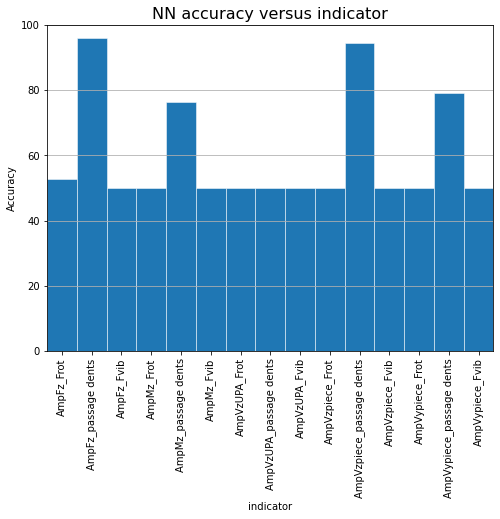

In [36]:
x = list(range(len(indic_elec)))
labels = [rank_label[1] for rank_label in indic_elec]
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x, accuracy, width=1,  edgecolor="white", linewidth=0.5)

width=1
ax.set_ylabel('Accuracy')
ax.set_xlabel('indicator')
ax.set_title('NN accuracy versus indicator', fontsize=16)
ax.set_xticks(x, labels,  rotation='vertical')
ax.set_xlim(0-width/2, len(indic_elec)-width/2)
ax.set_ylim(0,100)
ax.grid(axis='y')
plt.show()

# 5 $-$ Entraînement final avec les indicateurs de nature életrique les plus pertinents

Refaire l'entraînement du RND en ne conservant que les indicateurs électriques donnat une précision meilleure que 80 %, faire afficher la matrice de confusion...

In [37]:
indic_elec

[(35, 'AmpFz_Frot'),
 (36, 'AmpFz_passage dents'),
 (37, 'AmpFz_Fvib'),
 (38, 'AmpMz_Frot'),
 (39, 'AmpMz_passage dents'),
 (40, 'AmpMz_Fvib'),
 (41, 'AmpVzUPA_Frot'),
 (42, 'AmpVzUPA_passage dents'),
 (43, 'AmpVzUPA_Fvib'),
 (44, 'AmpVzpiece_Frot'),
 (45, 'AmpVzpiece_passage dents'),
 (46, 'AmpVzpiece_Fvib'),
 (47, 'AmpVypiece_Frot'),
 (48, 'AmpVypiece_passage dents'),
 (49, 'AmpVypiece_Fvib')]

In [38]:
accuracy = np.array(accuracy)
ranks = np.where(accuracy >= 80)[0]
ranks

array([ 1, 10])

Rangs et lables des indicateurs retenus :

In [39]:
best_indic_elec   = np.array(indic_elec)[ranks]
ranks_indic_elec  = [int(rank_label[0]) for rank_label in best_indic_elec]
labels_indic_elec = [rank_label[1] for rank_label in best_indic_elec]
ranks_indic_elec, labels_indic_elec

([36, 45], ['AmpFz_passage dents', 'AmpVzpiece_passage dents'])

In [41]:
# take the indicator and the label of rank <i>:
data_train_best = data_train[:,ranks_indic_elec]
data_val_best   = data_val[:,ranks_indic_elec]

In [42]:
data_train_best.shape, data_val_best.shape

((284, 2), (72, 2))

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

nb_train_set = data_train_best.shape[0]    # number of training sets
nb_val_set   = data_val_best.shape[0]      # number of validation sets 
set_size     = len(best_indic_elec)   # number of scalars in a set 
nb_classe    = 2                      # number of classes (material1, material2)

tf.random.set_seed(SEED)

# les 5 lignes pour construire le réseau de neurones:
model_2 = Sequential()
model_2.add(Input(shape=(set_size,), name='Input'))
model_2.add(Dense(100, activation='relu', name='C1'))
model_2.add(Dense(nb_classe, activation='softmax', name='Out'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

model_2.summary()    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Dense)                  (None, 100)               300       
                                                                 
 Out (Dense)                 (None, 2)                 202       
                                                                 
Total params: 502
Trainable params: 502
Non-trainable params: 0
_________________________________________________________________


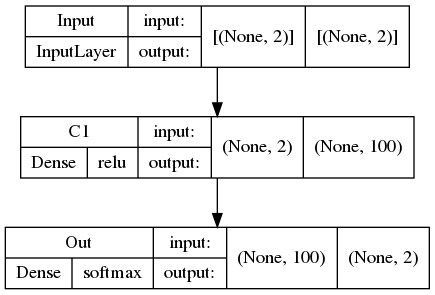

In [44]:
tf.keras.utils.plot_model(model_2, show_shapes=True, show_layer_activations=True)

In [45]:
tf.random.set_seed(SEED)
t0 = time()
hist = model_2.fit(data_train_best, y_train,
                   validation_data=(data_val_best, y_val), 
                   epochs=10, 
                   batch_size=128,
                   verbose=0)
temps_calcul = time() - t0
print(f"Durée entraînement : {temps_calcul:.2f} secondes")

Durée entraînement : 0.66 secondes


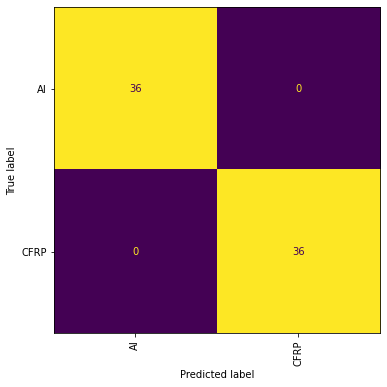

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

inf_best = model_2.predict(data_val_best).argmax(axis=-1)

fig = plt.figure(figsize=(6,6))
axis = plt.axes()
ConfusionMatrixDisplay.from_predictions(label_val, inf_best, 
                                        ax=axis,
                                        display_labels=['Al','CFRP'], 
                                        xticks_rotation='vertical',
                                        colorbar=False);

# 6 $-$ Bilan

On peut entraîner un simple réseau de neurones dense à reconnaître le matériau percé avec seulement 2 indicateurs calculés avec les données temporelles de capteurs électriques : <br>`'AmpFz_passage dents'` et `'AmpVzpiece_passage dents'`. 

L'entraînement avec ces 2 indicateurs dure moins de 1 seconde, la prédiction est quasi-instantannée.

Ceci permettrait de concevoir un *smart drilling bench" où les paramètres de perçage pourraient être ajustés en temps réel en fonction du matériau percé.